In [ ]:

import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Importations depuis transformers
from transformers import TFBertModel, BertTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Initialisation du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = pd.concat([train, valid]).reset_index(drop=True)
#train  = train.sample(frac=0.5, random_state=42).reset_index(drop=True)


In [ ]:
train.shape

(13784, 2)

<ipython-input-7-aa00f553e7ea>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x="intent", data=train, palette=HAPPY_COLORS_PALETTE)
<ipython-input-7-aa00f553e7ea>:1: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  chart = sns.countplot(x="intent", data=train, palette=HAPPY_COLORS_PALETTE)
<ipython-input-7-aa00f553e7ea>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')


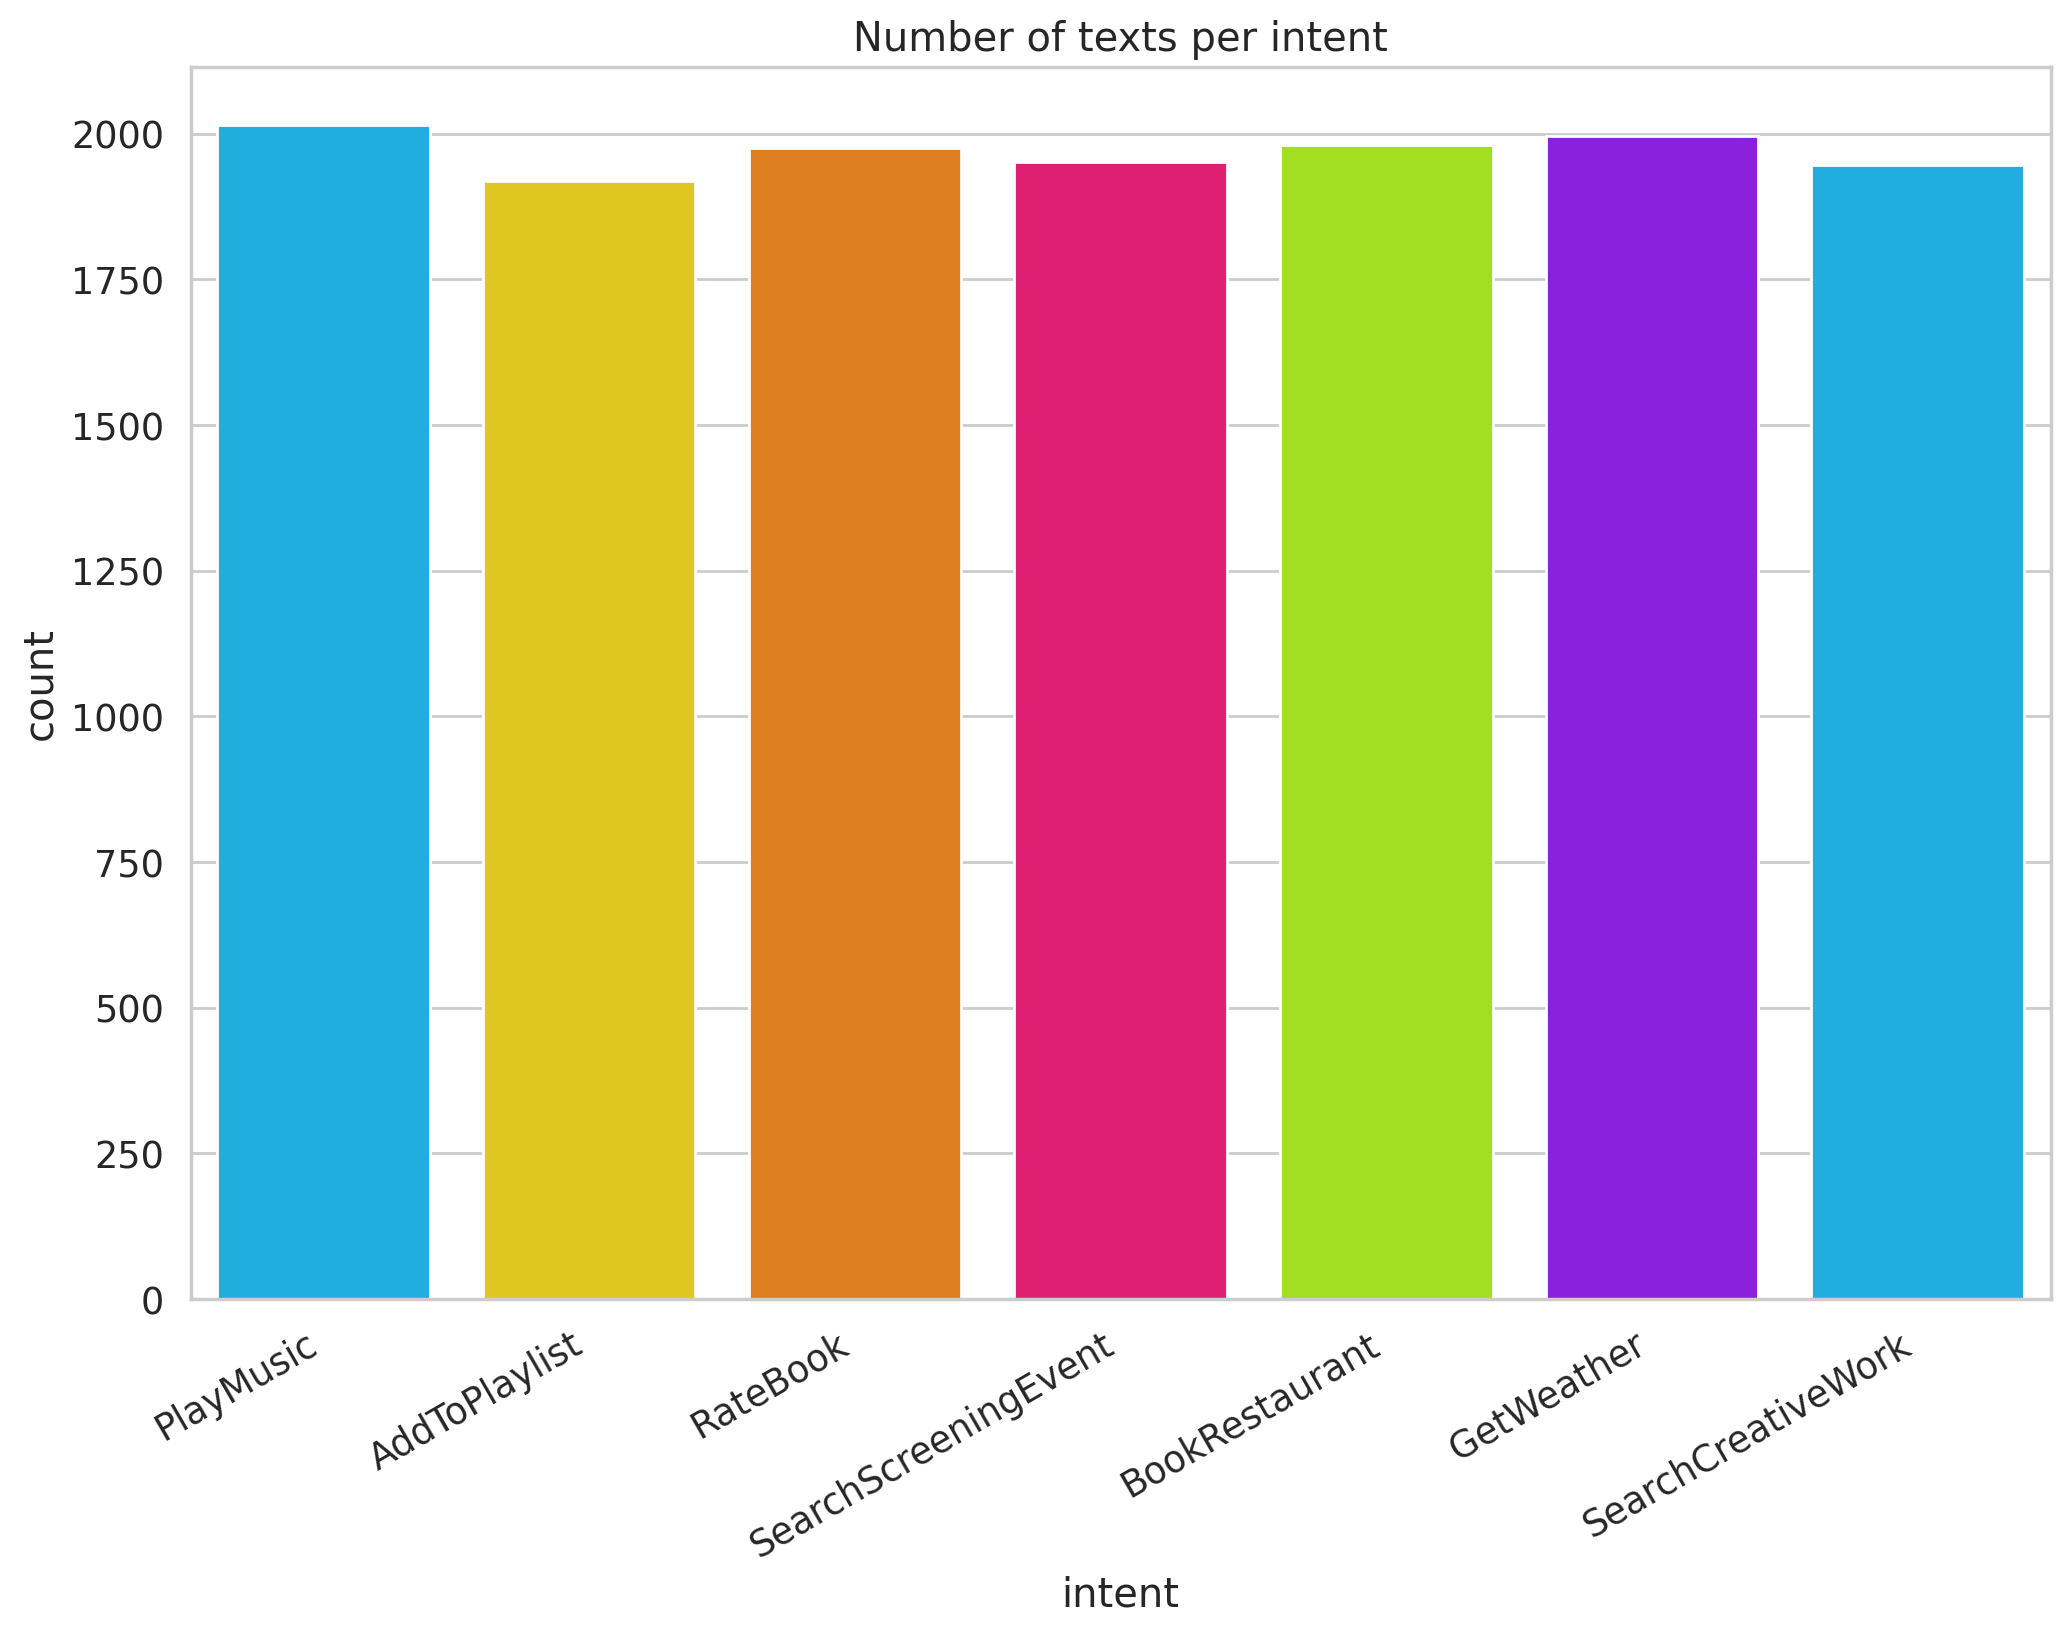

In [ ]:
chart = sns.countplot(x="intent", data=train, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [ ]:
from transformers import TFBertModel, BertTokenizer

# Initialisation du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Déverrouiller les couches BERT pour qu'elles soient entraînables
for layer in bert_model.layers:
    layer.trainable = True

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

In [ ]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer, classes, max_seq_len=128):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.classes = classes

        # Préparation des données d'entraînement et de test
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows(), total=len(df)):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            # Tokenization avec padding et ajout de masque d'attention
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # Ajoute [CLS] et [SEP]
                max_length=self.max_seq_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='np'
            )

            x.append(encoding['input_ids'].flatten())
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)


In [ ]:


def create_model(max_seq_len, num_classes):
    # Définir les entrées sans casting explicite
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

    # Obtenir les embeddings BERT sans utiliser le pooler
    bert_output = keras.layers.Lambda(
        lambda inputs: bert_model(input_ids=inputs[0], attention_mask=inputs[1])[0],
        output_shape=(max_seq_len, 768)
    )([input_ids, attention_mask])

    # Sélection de la sortie [CLS] pour la classification
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :], output_shape=(768,))(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)

    # Ajout de couches fully connected
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=num_classes, activation="softmax")(logits)

    # Création du modèle
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

    return model



# Liste des classes uniques, triées pour garantir la cohérence des labels
classes = sorted(train["intent"].unique().tolist())

# Création de l'objet de données avec la liste des classes et le tokenizer
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

100%|██████████| 700/700 [00:00<00:00, 2167.07it/s]


In [ ]:
# Création du modèle en utilisant la longueur de séquence maximale et le nombre de classes
model = create_model(max_seq_len=data.max_seq_len, num_classes=len(data.classes))


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'tf_bert_model_1/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model_1/bert/encoder/layer_._0/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 lambda (Lambda)             (None, 128, 768)             0         ['input_ids[0][0]',           
                                                                     'attention_mask[0][0]']      
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Chemin pour sauvegarder les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Définir le callback de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq='batch', write_graph=False)

# Création des masques d'attention pour les données d'entraînement
attention_masks = np.where(data.train_x != 0, 1, 0)

# Entraînement du modèle
history = model.fit(
    x={'input_ids': data.train_x, 'attention_mask': attention_masks},
    y=data.train_y,
    validation_split=0.1,
    batch_size=16,
    shuffle=True,
    epochs=20,
   # callbacks=[tensorboard_callback]
)


Epoch 1/20
776/776 [==============================] - 158s 181ms/step - loss: 1.4905 - accuracy: 0.4575 - val_loss: 0.6337 - val_accuracy: 0.8687
Epoch 2/20
776/776 [==============================] - 134s 173ms/step - loss: 0.8289 - accuracy: 0.7308 - val_loss: 0.3834 - val_accuracy: 0.9152
Epoch 3/20
776/776 [==============================] - 142s 183ms/step - loss: 0.5878 - accuracy: 0.8210 - val_loss: 0.2789 - val_accuracy: 0.9333
Epoch 4/20
776/776 [==============================] - 142s 183ms/step - loss: 0.4832 - accuracy: 0.8544 - val_loss: 0.2310 - val_accuracy: 0.9434
Epoch 5/20
776/776 [==============================] - 143s 184ms/step - loss: 0.4134 - accuracy: 0.8738 - val_loss: 0.1974 - val_accuracy: 0.9492
Epoch 6/20
776/776 [==============================] - 142s 183ms/step - loss: 0.3722 - accuracy: 0.8829 - val_loss: 0.1743 - val_accuracy: 0.9587
Epoch 7/20
776/776 [==============================] - 143s 184ms/step - loss: 0.3461 - accuracy: 0.8916 - val_loss: 0.1584 -

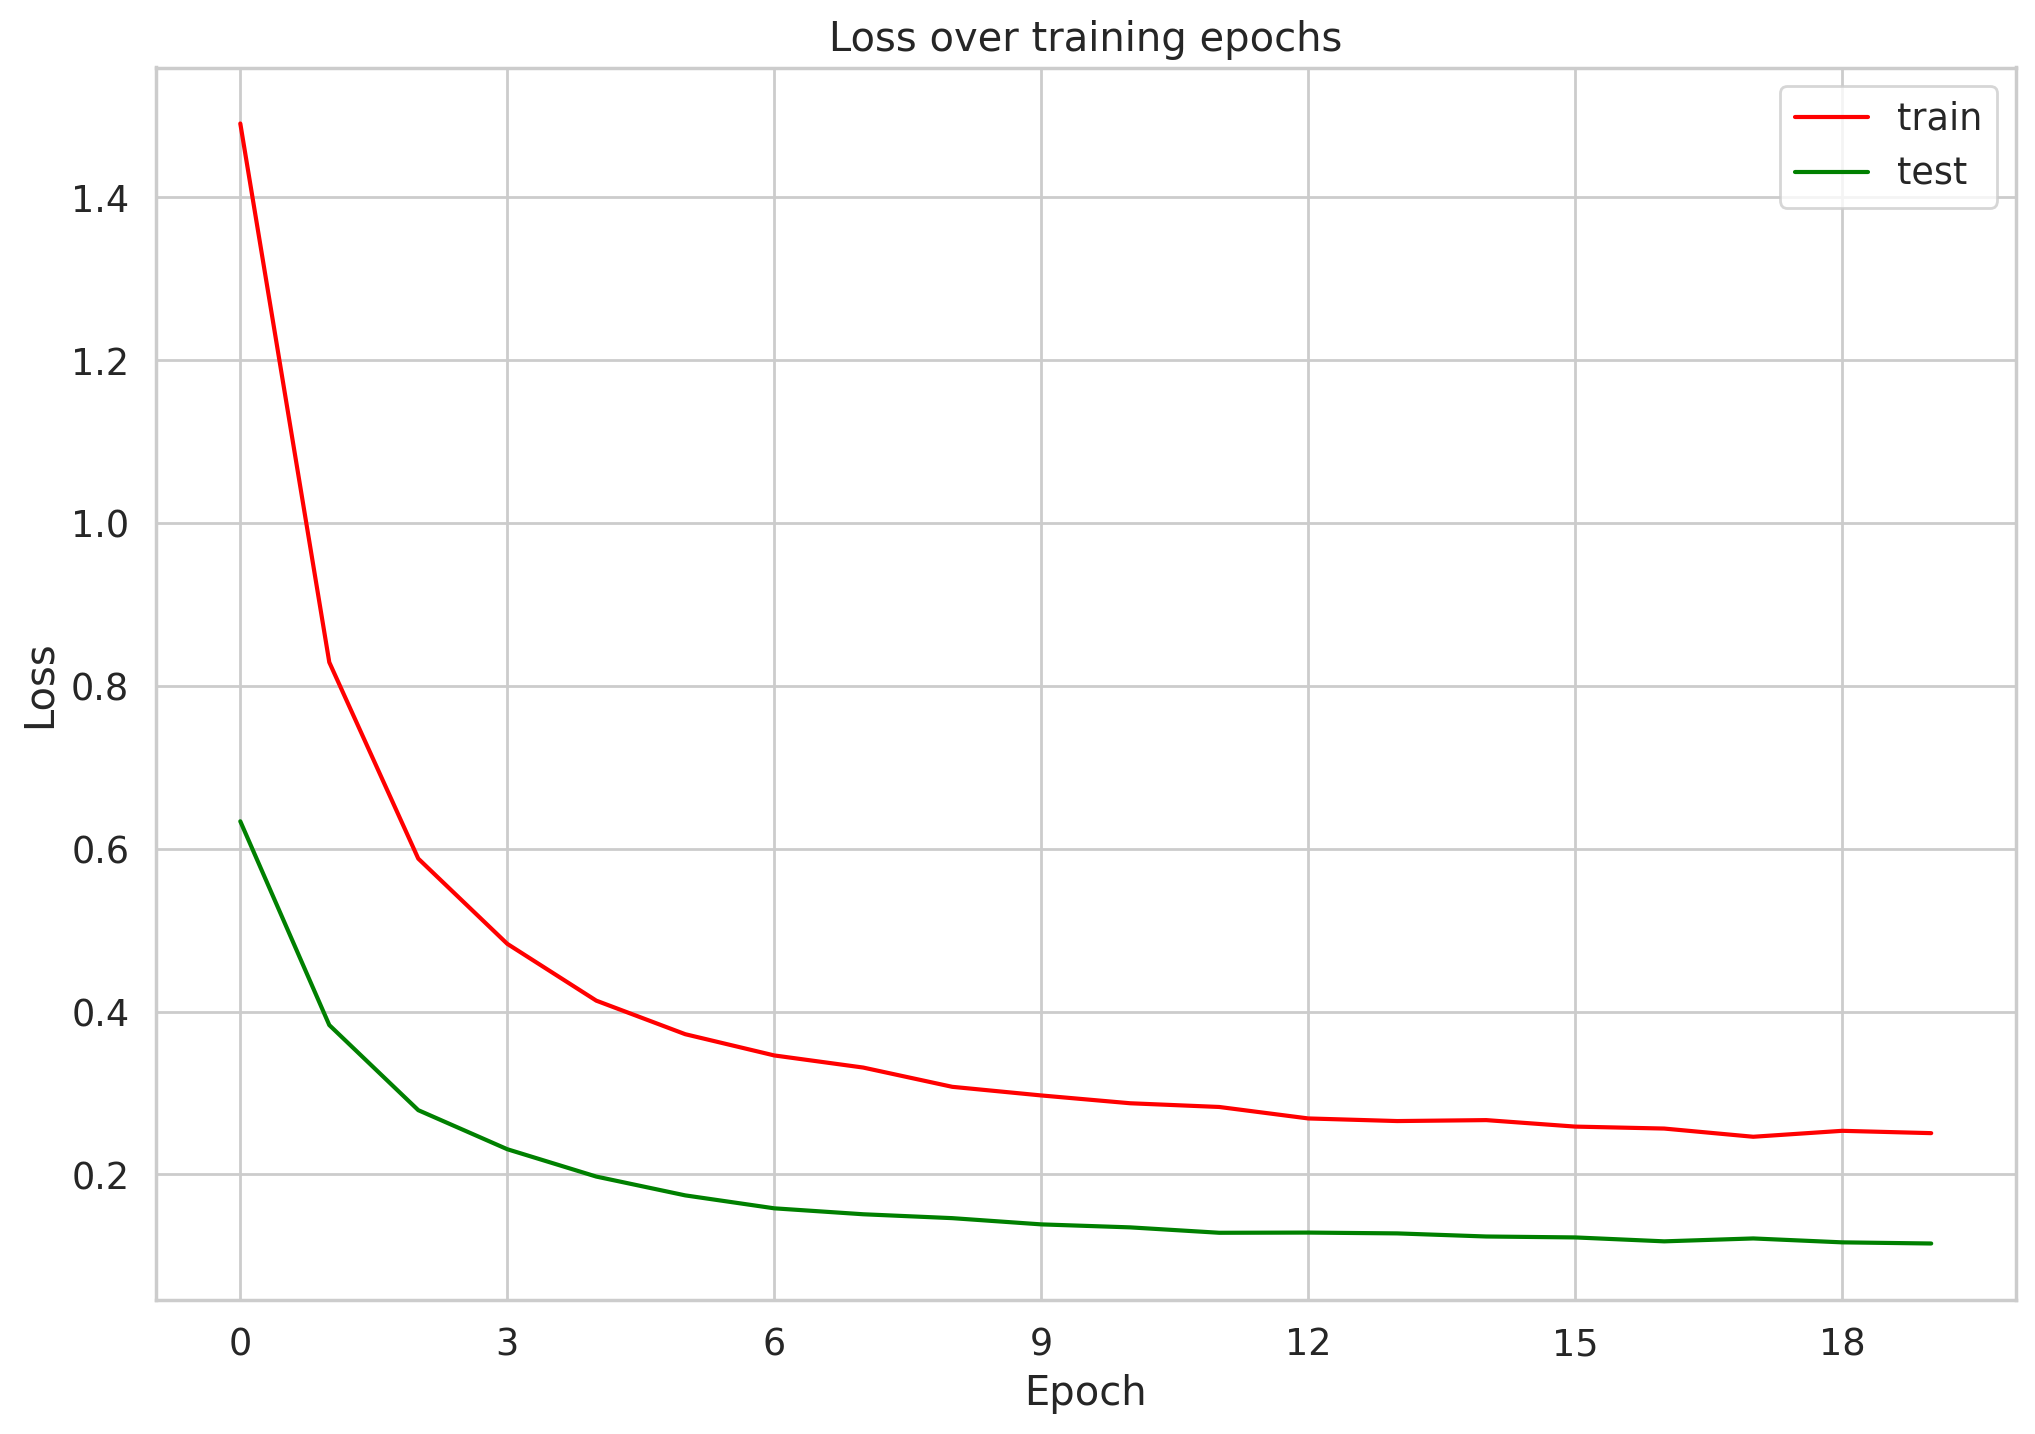

In [ ]:

# Créer la figure et configurer l'axe
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Tracer les courbes avec des couleurs personnalisées
ax.plot(history.history['loss'], color='red')  # Couleur pour la courbe de perte d'entraînement
ax.plot(history.history['val_loss'], color='green')  # Couleur pour la courbe de validation

# Configurer les légendes, labels et titre
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

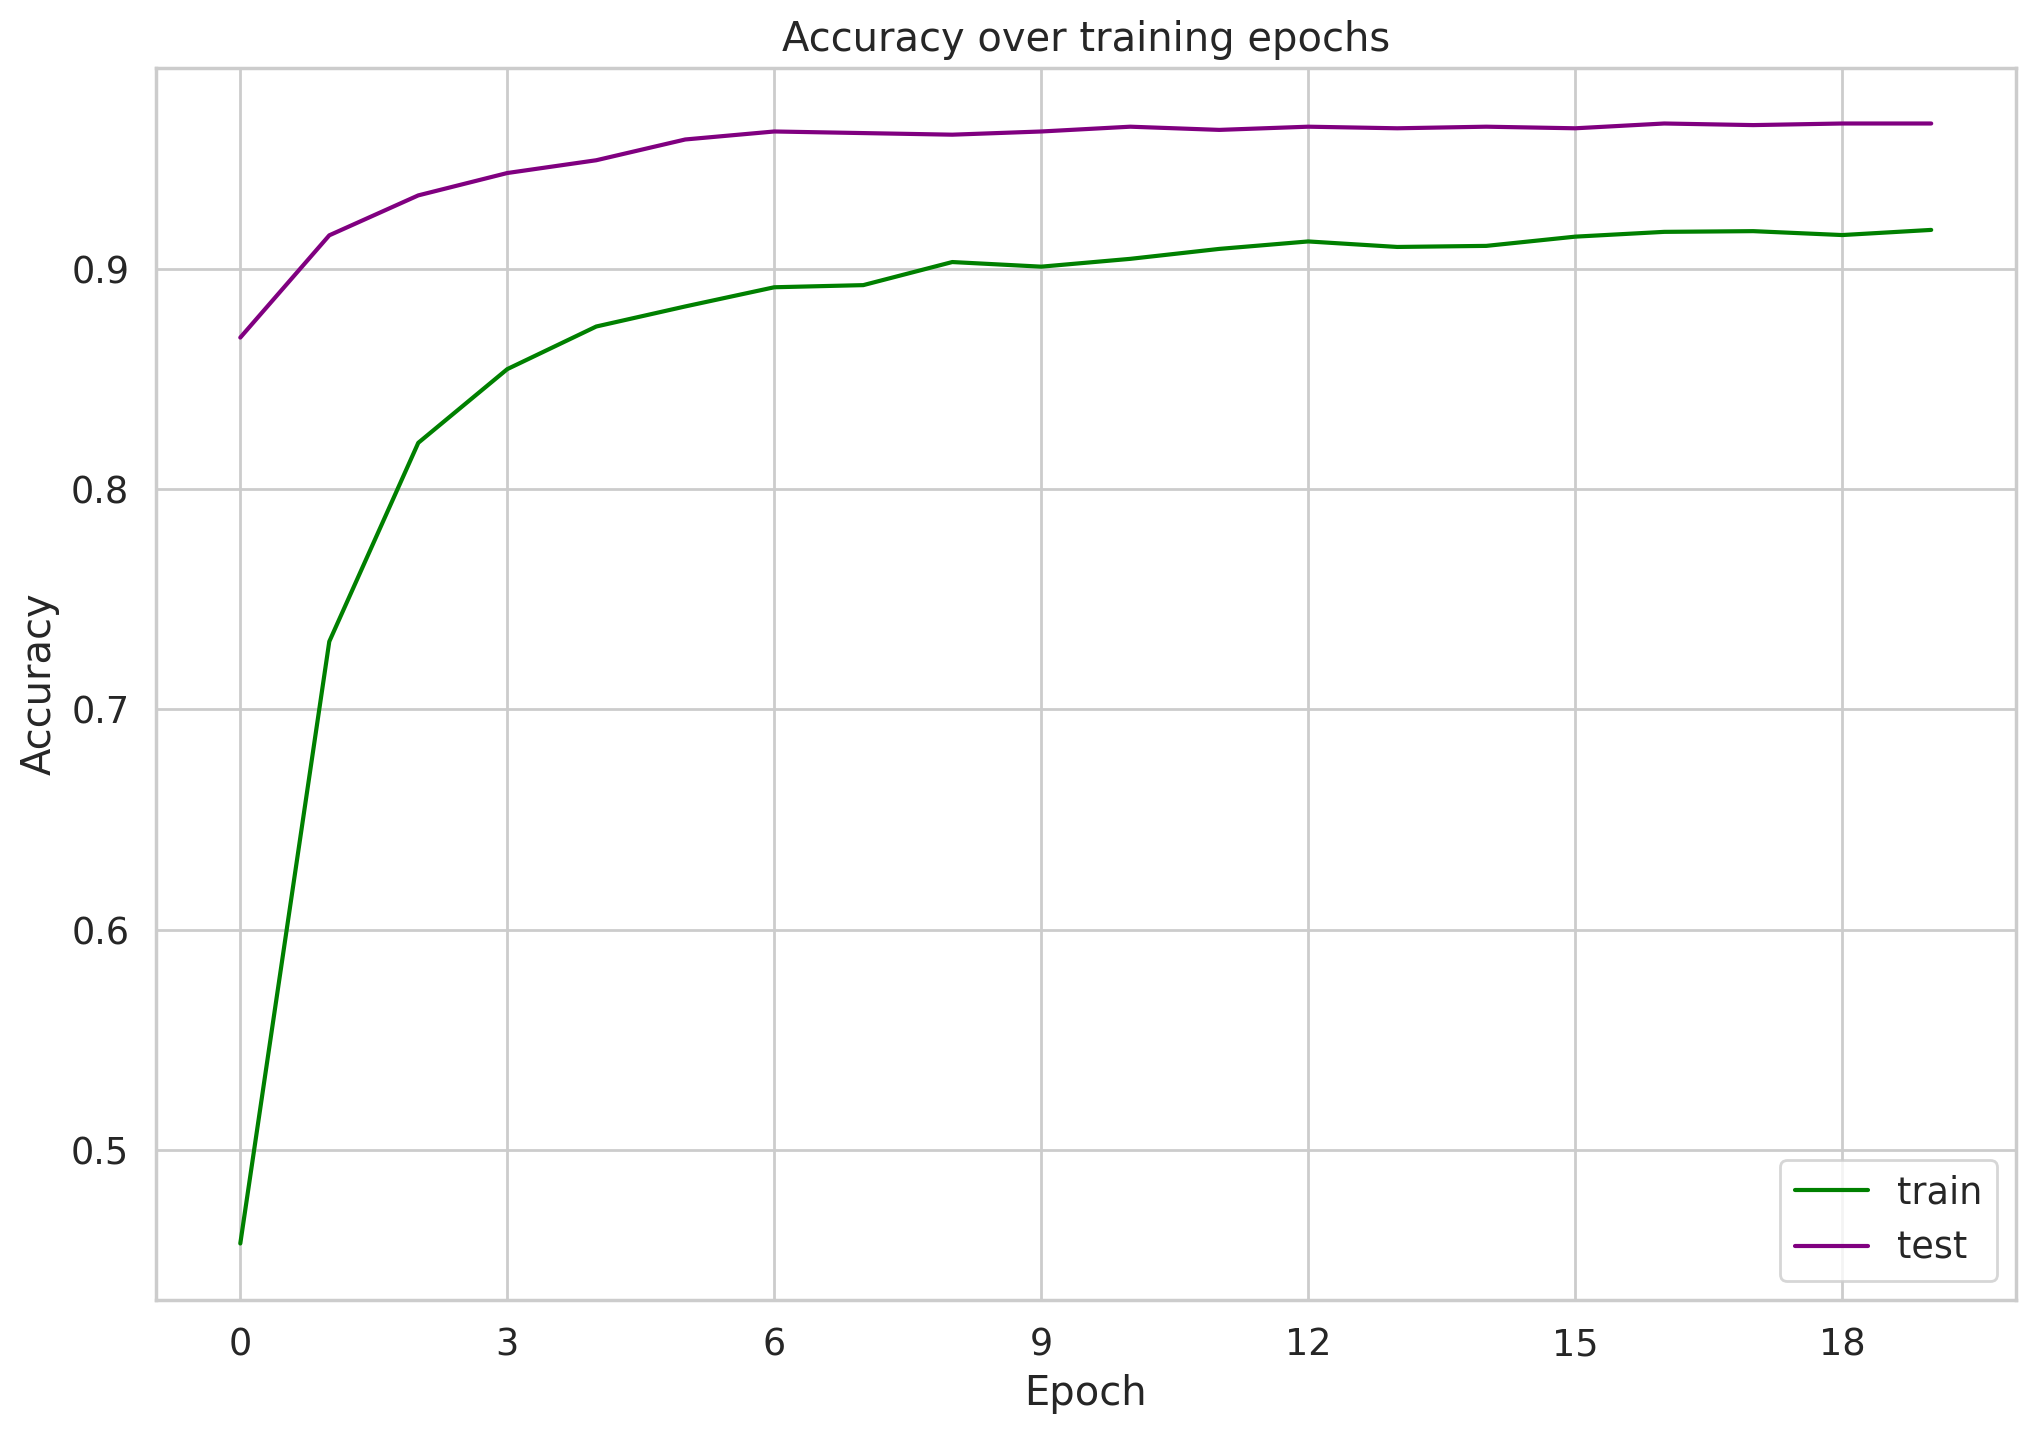

In [ ]:
# Créer la figure et configurer l'axe
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Tracer les courbes avec des couleurs personnalisées
ax.plot(history.history['accuracy'], color='green')       # Couleur pour la courbe d'exactitude d'entraînement
ax.plot(history.history['val_accuracy'], color='purple')  # Couleur pour la courbe d'exactitude de validation

# Configurer les légendes, labels et titre
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show()

In [ ]:
# Préparation des données d'entrée (si ce n'est pas déjà fait)
train_input_ids = data.train_x  # Supposons que data.train_x soit déjà un tableau numpy
train_attention_mask = (train_input_ids != 0).astype(int)  # Crée un masque d'attention : 1 si ce n'est pas un token de remplissage, sinon 0

test_input_ids = data.test_x  # Supposons que data.test_x soit également un tableau numpy
test_attention_mask = (test_input_ids != 0).astype(int)  # Crée le masque d'attention pour le test

# Évaluation du modèle
train_loss, train_acc = model.evaluate([train_input_ids, train_attention_mask], data.train_y)
test_loss, test_acc = model.evaluate([test_input_ids, test_attention_mask], data.test_y)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


22/22 [==============================] - 6s 281ms/step - loss: 0.1749 - accuracy: 0.9357
Train Accuracy: 0.9693122506141663
Test Accuracy: 0.9357143044471741


In [ ]:
test_input_ids = data.test_x  # Supposons que data.test_x soit également un tableau numpy
test_attention_mask = (test_input_ids != 0).astype(int)  # Crée le masque d'attention pour le test

# Évaluation du modèle
test_loss, test_acc = model.evaluate([test_input_ids, test_attention_mask], data.test_y)
print("Test Accuracy:", test_acc)

22/22 [==============================] - 7s 296ms/step - loss: 0.1749 - accuracy: 0.9357
Test Accuracy: 0.9357143044471741


22/22 [==============================] - 9s 283ms/step
Matrice de confusion :
 [[116   1   0   2   0   5   0]
 [  0  91   0   0   0   0   1]
 [  0   2 102   0   0   0   0]
 [  2   0   0  81   0   3   0]
 [  0   0   0   0  80   0   0]
 [  0   0   0   6   0  94   7]
 [  0   0   0   0   0  16  91]]


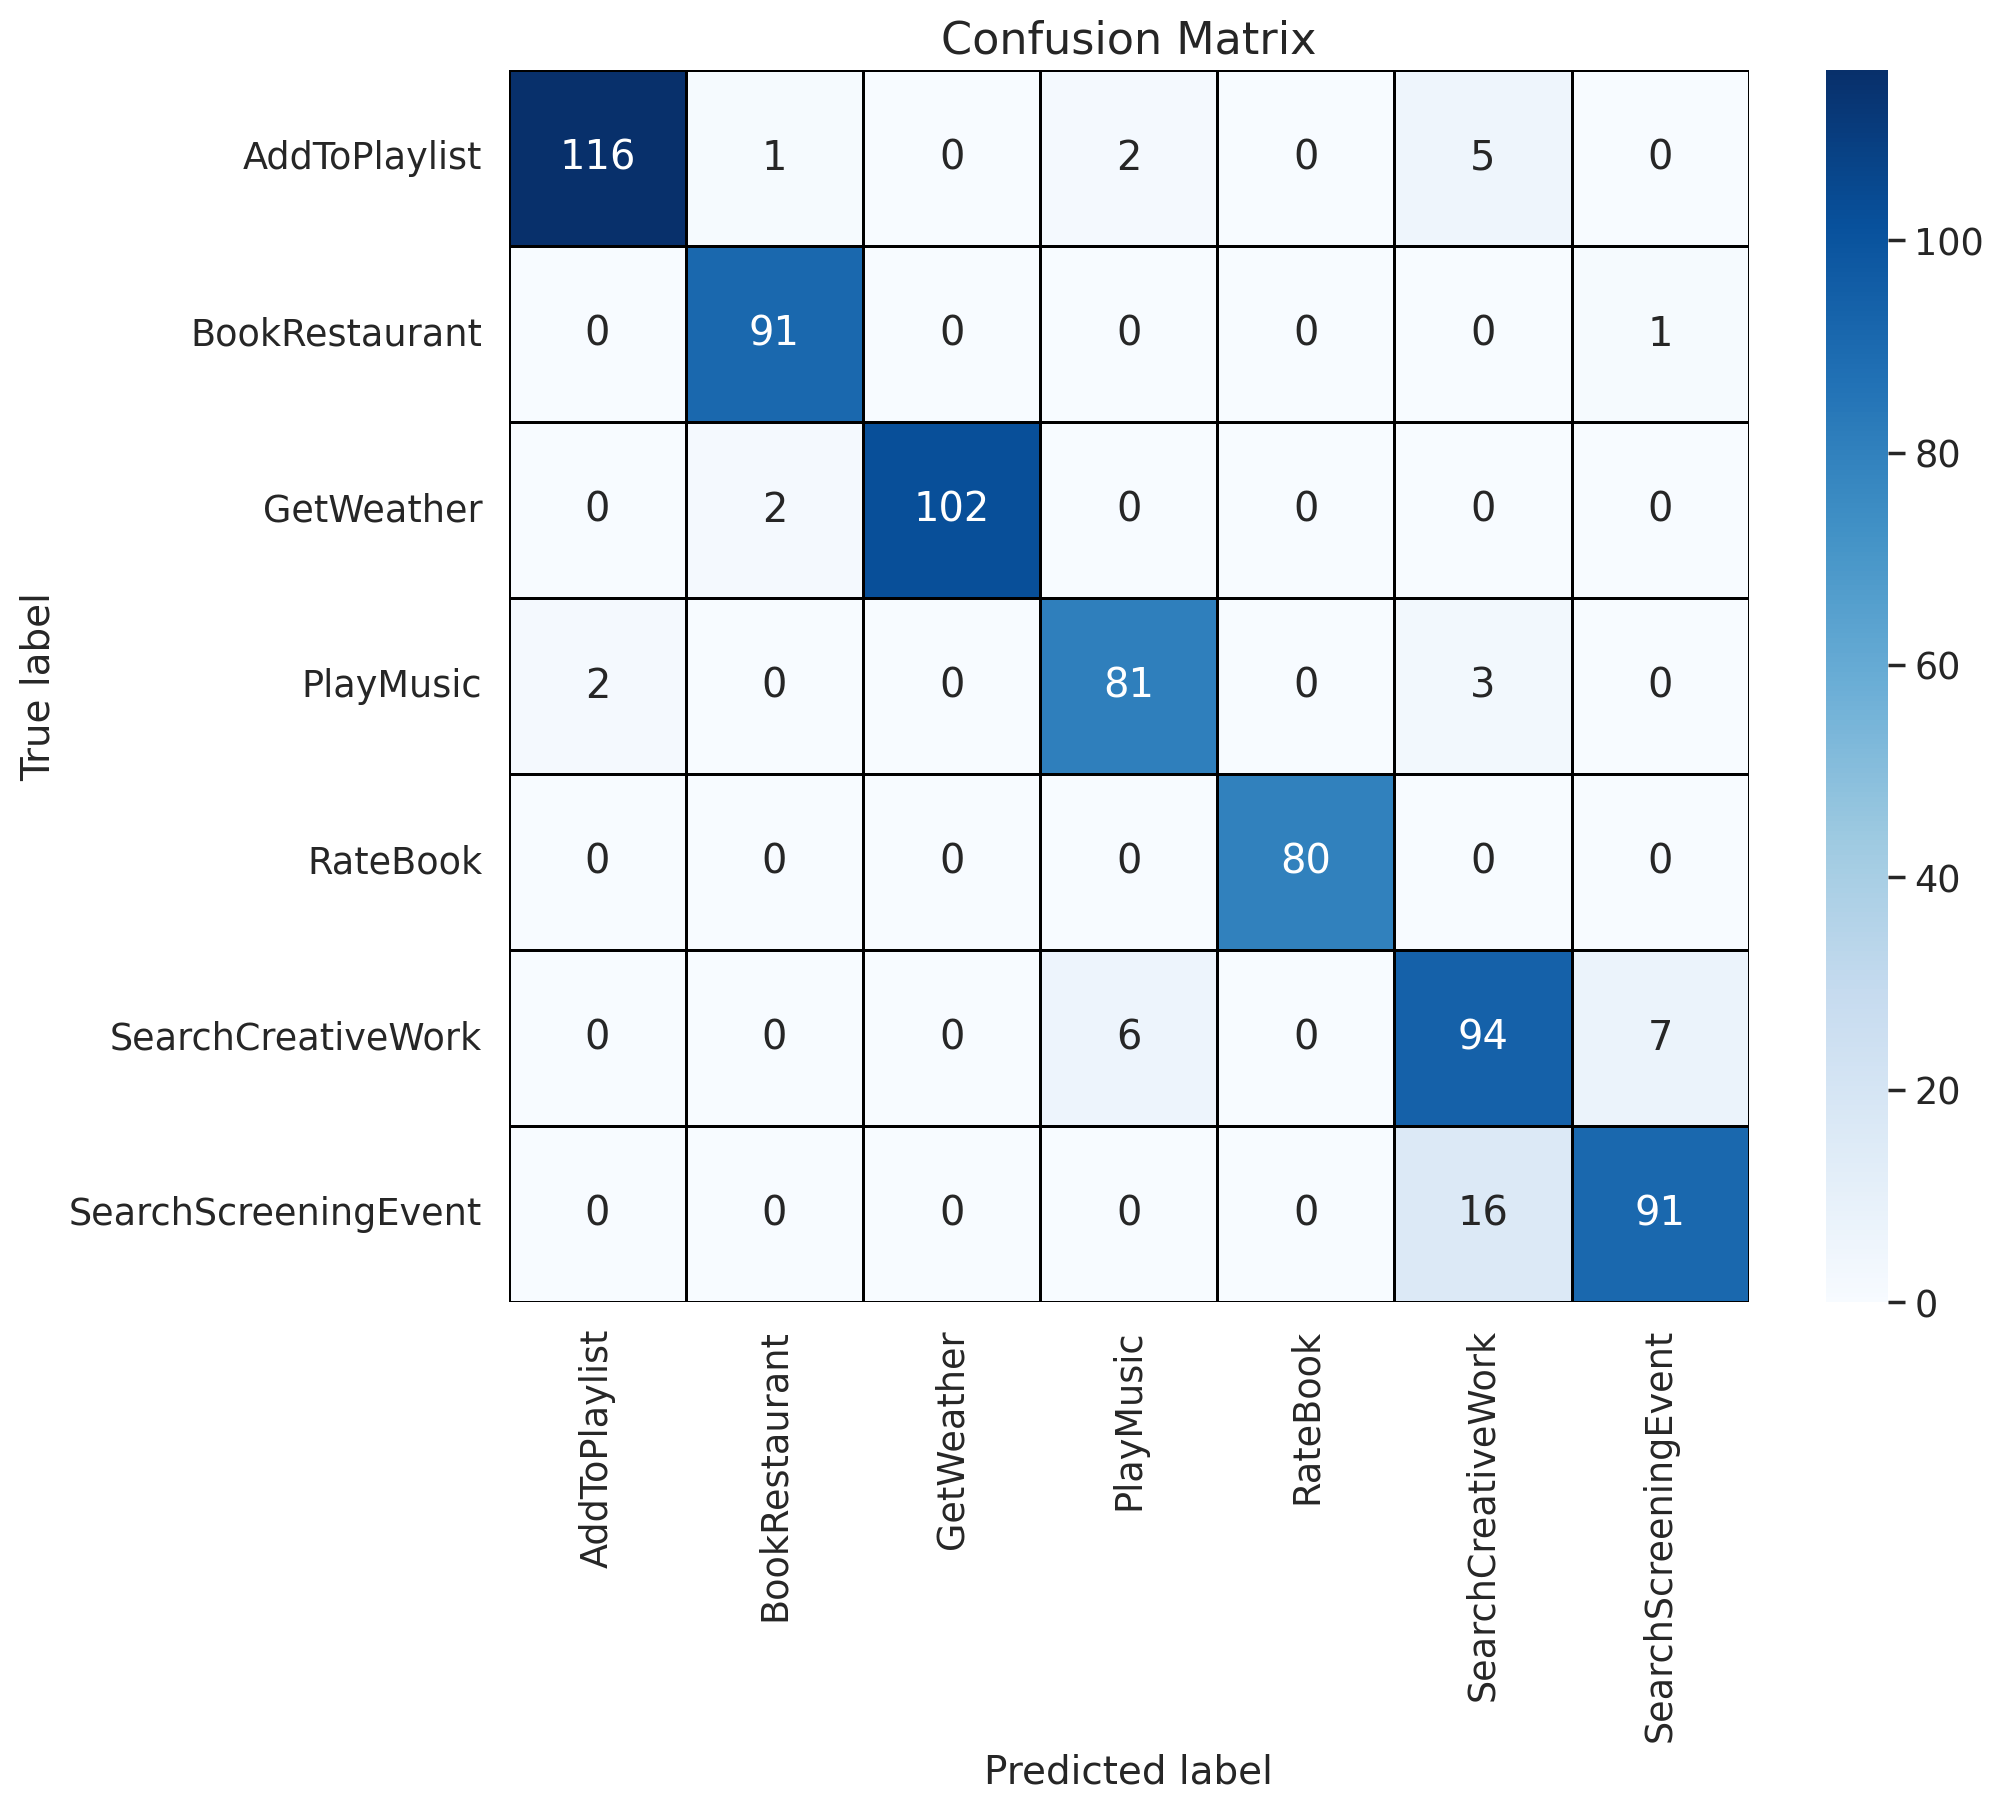

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Prédictions sur les données de test
y_pred_prob = model.predict([test_input_ids, test_attention_mask])  # Obtenir les probabilités des classes
y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir les probabilités en classes

# Créer la matrice de confusion
cm = confusion_matrix(data.test_y, y_pred)

# Afficher la matrice de confusion pour vérifier les valeurs
print("Matrice de confusion :\n", cm)

# Convertir en DataFrame pour seaborn
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

# Vérifier si la matrice de confusion contient des valeurs
if df_cm.isnull().values.any():
    print("La matrice de confusion contient des valeurs nulles.")

# Personnaliser le heatmap
plt.figure(figsize=(10, 8))  # Ajuster la taille de la figure
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=.5, linecolor='black')  # Modifier la palette de couleurs

# Ajouter des labels et un titre
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)  # Ajouter un titre

plt.show()  # Afficher le graphique


In [ ]:
import numpy as np

# Liste des classes du SNIPS dataset
classes = [
    "addToPlay",
    "bookRestaurant",
    "getWeather",
    "playMusic",
    "rateBook",
    "searchCreativeWork",
    "searchScreeningEvent"
]

# Fonction de prédiction pour le modèle déjà entraîné
def predict_intent(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'
    )

    input_ids = encoding['input_ids']
    attention_mask = np.where(input_ids != 0, 1, 0)

    # Utilisez le modèle directement sans le recharger
    preds = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})
    predicted_class_index = np.argmax(preds, axis=1)[0]

    # Retourner le nom de la classe
    predicted_class_name = classes[predicted_class_index]

    return predicted_class_name

# Testez le modèle avec une phrase
text_input = "I'd like to listen to some classic rock right now."  # Exemple de phrase à tester
predicted_class_name = predict_intent(text_input)
print(f"L'intention prédite pour '{text_input}' est : {predicted_class_name}")


1/1 [==============================] - 3s 3s/step
L'intention prédite pour 'I'd like to listen to some classic rock right now.' est : playMusic


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [ ]:
from fastai.vision.all import *
import gradio as gr
import numpy as np

# Prediction function
def predict_intent(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'
    )

    input_ids = encoding['input_ids']
    attention_mask = np.where(input_ids != 0, 1, 0)

    # Predict intent
    preds = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})
    predicted_class_index = np.argmax(preds, axis=1)[0]
    predicted_class_name = classes[predicted_class_index]

    return predicted_class_name

# Gradio interface setup
iface = gr.Interface(
    fn=predict_intent,
    inputs="text",
    outputs="text",
    title="Intent Detection",
    description="Enter a phrase to predict the intent."
)

# Launch the Gradio interface with sharing
iface.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://43b44691863c60e03c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
